# DNA Sequence Comparison
__October, 2018 - Christopher Sanchez__ 

Deoxyribonucleic acid, or DNA is a double helix shaped structure consisting of a chain of nucleotides known as basepairs that act like an algorithm, providing a list of instructions for your body to create proteins. There are four distinct bases A, T, C and G. A always bonds with T and C always bonds with G. A wide variety of information can be gained from DNA analysis. It is possible to determine gender, disease susceptibility, familial ties, DNA is responsible for solving countless amounts of crime, and more! There are multiple sequencing techniques out there, but not all are great for error. I was inspired by this paper: https://www.cse.unr.edu/~cheung/neorgene.pdf, to attempt improving the dna sequencing techniques that are used today. A LSTM RNN is perfect for the task, because it works well with error. A human genome consists of six billion basepairs mistakes are going to be made. It isn't uncommon for a basepair to get switched around. It is important to use a technique that can operate quickly and accurately. 

Genetic algorithms are very interesting. They work by mimicing the darwin evolutionary theory. Genetic algorithms are similar to a brute force technique, but operate much faster. A genetic algorithm will be used to train a recurrent neural network rather than back propagation. First a population is created, in this case it will be 30 LSTM Recurrent neural networks. The second step is to determine a fitness score, to determine whether a network is worth keeping or not. Next it is important to grade or sort the networks into fit and unfit categories, the 10 fittest networks will be kept and the 20 weakest networks will be killed off. Finally the networks must be bred and evolved. The population will be given a fitness score which is the mean squared error, sorted from fittest to weakest, the top 10 fittest networks will be kept. The weights from the 10 fittest networks will be used to create 20 new networks. The process will be repeated until the desired score is met. 

In [1]:
import numpy as np
import pandas as pd
import re
from numpy import argmax, array
import matplotlib.pyplot as plt
import keras
import tensorflow
# Import various componenets for model building
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, TimeDistributed, SimpleRNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import bernoulli
# Import the backend
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences


/Users/c/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/c/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The DNA Sequence that will be used is the sequence for chromosome 21. The sequence is LOCUS NT_187300, and is 156,246 base pairs long. It is important to remove the extra numbers, new lines and white spaces.

In [2]:
with open('dna.txt', 'r') as myfile:
  dna = myfile.read()
dna_basepairs = dna
dna_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', dna_basepairs)
dna_basepairs = re.sub(r'\n', '', dna_basepairs)
dna_basepairs = re.sub(r'\s+', '', dna_basepairs).strip()

In [3]:
def population(data, timesteps):
    # split the sequence in two
    sequence_one = data[:75000]
    sequence_two = data[75000:150000]
    # timesteps and samples to determine reshape size
    timesteps = timesteps
    samples = int(len(sequence_one) / timesteps)
    
    # Create an array of zeros to be manipulated
    array = np.zeros((len(sequence_one),8))
    
    # mutating the array to effectively vectorize the basepairs.
    vectorize_sequence = {'a': 1, 't': 2, 'g': 3, 'c': 4}

    for base in range(len(sequence_one)):
        base_one = sequence_one[base]
        base_two = sequence_two[base]
        array[base, vectorize_sequence[base_one]] = 1
        array[base, vectorize_sequence[base_two] + 3] = 1
    
    # determine whether sequences are similar or not
    similarity_array = np.zeros((len(array),1))
    similarity_array = np.asarray([similarity_array[i] == 1 if np.equal(array[i, :4], array[i, 4:]).all() else similarity_array[i] == 0 for i in range(len(array))])
        
    
    return np.asarray(array).reshape(samples, timesteps, 8), similarity_array.reshape(samples, timesteps, 1)

In [4]:
# Creating the data
comparison, similarity_array = population(dna_basepairs, 50)

print(comparison.shape, similarity_array.shape)

(1500, 50, 8) (1500, 50, 1)


In [5]:
# Create train, test, and validation splits for the sequences being compared, and whether they are similar
X_train, X_validate, X_test = np.split(comparison, [int(.5*len(comparison)), int(.75*len(comparison))])
y_train, y_validate, y_test = np.split(similarity_array, [int(.5*len(similarity_array)), int(.75*len(similarity_array))])

#view the various lengths of the split data.
print('Train length:', len(X_train), '\n', 'Test length:', len(X_test), '\n', 'Validation length:', len(X_validate))

Train length: 750 
 Test length: 375 
 Validation length: 375


### I: Creating the population


The population of the experiment will consist of 30 LSTM networks with one lstm layer and a dense layer. It will accept an input of 8 input nodes.

In [6]:
network_population = []
for i in range(30):
    model = Sequential()
    # add Long short term memory RNN and a dense layer. Compile the model
    model.add(LSTM(10, input_shape=(comparison.shape[1],8), activation='tanh', return_sequences=True, use_bias=True))
    model.add(Dense(1, activation='tanh', use_bias=True))
    network_population.append(model)

### II: Grading the population:

In order to grade the population. The grading function takes in the population of networks, makes a prediction, calculates the mean squared error of the prediction through 150 epochs for each network, and then sorts the fittest networks from the weakest, returning a list that contains the strongest networks, weakest networks and the score of the mean squared error from each network and epoch.

In [7]:
def grade(pop):
    # mse_vec stores the mean squared error score for each network in the population
    #network counter and score are used to keep track of the mean squared error in epochs
#     mse_vec = []
#     network_counter = 0
#     score = dict()
    for i in pop:
        #for n in range(150):
        # calculate mean squared error
        def mse(y_true, y_pred):
            y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
            y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
            mse = mean_squared_error(y_true, y_pred)
            return mse
        y_pred = i.predict(X_train)
        mse = mse(y_train, y_pred)
        # keep track of epochs
#             z = str(network_counter) + '_' + str(n)
#             score[z] = mse
#         network_counter +=1
        mse_vec.append(mse)
    # convert mse_vec list to array
    mse_vec = np.asarray(mse_vec)


    # arg sort MSE and separate the fittest networks from the weakest.
    sorted_mse_idx = np.argsort(mse_vec)
    fittest_mse = sorted_mse_idx[:10]
    weakest_mse = sorted_mse_idx[10:]

    fittest_models = []
    weakest_models = []

    for model in fittest_mse:
        fittest_models.append(network_population[model])
    for model in weakest_mse:
        weakest_models.append(network_population[model])
    return [fittest_models, weakest_models, score]

### III: Mutate

The crossover function takes the fittest and weakest networks as inputs. First an array of random index's will be selected, then random weights will be selected from the fittest networks at the previously selected random index, and they will be used to replace the index of randomly selected weights from the weakest networks.

In [8]:
def crossover(fittest, weakest):
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()
    random_weights = []
    # randomly select index's of array to be replaced
    for layer in fittest_weights:
        random_weights.append(bernoulli.rvs(.5, size=layer.shape))
    #select weights to take from fittest weights
    select_fittest = [random_layer * network_layer for random_layer, network_layer in zip(random_weights, fittest_weights)]
    # select weakest weights to kill off
    kill_weakest = [(1 - random_layer) * network_layer for random_layer, network_layer in zip(random_weights, weakest_weights)]
    # create the new array of weights by combining the weights from the fittest models with the weights from the weakest models
    new_weights = [kill_weakest_layer + select_fittest_layer for kill_weakest_layer, select_fittest_layer in zip(select_fittest, kill_weakest)]
    weakest.set_weights(new_weights)

### IV: Breed

A network from each of the networks will be selected to act as partents. The crossover function will then be used to mutate the networks, thereby breeding new networks. The newest mutated population will be returned.

In [9]:
def breed(fittest, weakest):
    for weakest_model in weakest:
        #choose random model to take weights from
        fittest_model = np.random.choice(fittest)
        #crossover weights
        crossover(fittest_model, weakest_model)
    network_population = fittest + weakest
    return network_population

### V: Evolve

The genetic algorithm will be ran 30 times. First it will grade the network population, then breed the population. After the population has been bred the network population will be updated to reflect the newest networks.

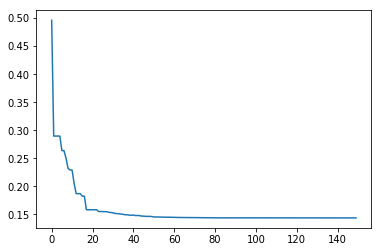

In [10]:
# set the network population to the original generated network population
network_population = network_population
graph_mse = []
# run 150 epochs
for x in range(150):
    # grade the network population and breed it
    grade_network = grade(network_population)
    breed_networks = breed(grade_network[0], grade_network[1])
    # set the network population to the new offspring
    network_population = breed_networks
    def mse(y_true, y_pred):
        y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        mse = mean_squared_error(y_true, y_pred)
        return mse
    # add the top network score to a list for each epoch and graph it
    y_pred = network_population[0].predict(comparison)
    mse = mse(similarity_array, y_pred)
    graph_mse.append(mse)
plt.plot(graph_mse)
plt.show()

In [ ]:
# need to add text here 

In [12]:
def mse(y_true, y_pred):
        y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        mse = mean_squared_error(y_true, y_pred)
        return mse

# run the best network on the test data to test for consistency.
y_pred = network_population[0].predict(X_test)
mse = mse(y_test, y_pred)

In [13]:
mse

0.14613712

## Discussion and Conclusion